In [1]:
DATASET_data="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"
DATASET_MC_v1="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.root"
DATASET_MC_v2="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v2.root"

In [2]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist

hep.style.use('ATLAS')

In [3]:
runs = [1720, 1721, 1722, 1723, 1724]#, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 2004, 2005, 2006, 2007, 2008, 2009, 2015, 2024, 2025, 2026, 2027, 2028]
processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False)
filelist_data = processor.getFilelist(DATASET_data, root_schema=True)
#append "run" at the end of each file name
filelist_data = ["{}{}".format(i, ":run") for i in filelist_data]

In [46]:
processor = wideband.DataProcessor(treename='CrvWidebandTest/run', runlist=[1738], userunlist=False, remove=False)

filelist_mc_v1 = processor.getFilelist(DATASET_MC_v1, root_schema=True)
#append "run" at the end of each file name
#filelist_mc = ["{}{}".format(i, ":CrvWidebandTest/WidebandTree") for i in filelist_mc]
filelist_mc_v1 = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist_mc_v1]

filelist_mc_v2 = processor.getFilelist(DATASET_MC_v2, root_schema=True)
#append "run" at the end of each file name
filelist_mc_v2 = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist_mc_v2]

In [29]:
# Real Wideband data

# List of variable to import
varlist=['PEs', 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
varlist_keep = ['PEs_testlayers', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
#varlist_keep = ['PEs_testlayers', 'trackIntercept', 'trackChi2NDF', 'trackPoints', 'trackPEs', 
#         'PEsPerHit', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']

ar_skim_list_cleanup_data = []
ar_skim_list_169_data = []

histbins = np.linspace(2,400,800)
hPEs_data, bins = np.histogram([], bins=histbins)

trackPEs_histbins = np.linspace(0, 5000, 251)
hTrackPEs_data = np.histogram([], bins=trackPEs_histbins)

trackChi2NDF_histbins = np.linspace(0, 100, 101)
hTrackChi2NDF_data = np.histogram([], bins=trackChi2NDF_histbins)

allevents = 0
cutevents_cleanup = 0
cutevents_169 = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist_data):
    if idx%100 == 0:
        print("Processing file: %s"%filename)
    allfiles += 1
    try:
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])

                ar["PEs"] = ak.where(ar["PEs"] >= 5, ar["PEs"], 0)

                FEB0_0 = (ak.sum(ar["PEs"][:,0,8:32], axis=-1)>10)
                FEB0_1 = (ak.sum(ar["PEs"][:,0,32:64], axis=-1)>10)

                FEB1_0 = (ak.sum(ar["PEs"][:,1,4:28], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar["PEs"][:,1,36:60], axis=-1)>10)

                FEB2_0 = (ak.sum(ar["PEs"][:,2,4:28], axis=-1)>10)
                FEB2_1 = (ak.sum(ar["PEs"][:,2,36:60], axis=-1)>10) #32:64

                FEB3_0 = (ak.sum(ar["PEs"][:,3,8:32], axis=-1)>10)
                FEB3_1 = (ak.sum(ar["PEs"][:,3,32:64], axis=-1)>10)

                FEB4_0 = (ak.sum(ar["PEs"][:,4,0:32], axis=-1)>10)
                FEB4_1 = (ak.sum(ar["PEs"][:,4,32:64], axis=-1)>10)

                FEB5_0 = (ak.sum(ar["PEs"][:,5,0:32], axis=-1)>10)
                FEB5_1 = (ak.sum(ar["PEs"][:,5,32:64], axis=-1)>10)

                FEB6_0 = (ak.sum(ar["PEs"][:,6,0:32], axis=-1)>10)
                FEB6_1 = (ak.sum(ar["PEs"][:,6,32:64], axis=-1)>10)

                FEB7_0 = (ak.sum(ar["PEs"][:,7,8:32], axis=-1)>10)
                FEB7_1 = (ak.sum(ar["PEs"][:,7,32:64], axis=-1)>10)

                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")

                hPEsRun, bins = np.histogram(ak.flatten(ar["PEs"][:,1,0:64]), bins=histbins)
                hPEs_data = np.add(hPEs_data, hPEsRun)
                hPEsRun, bins = np.histogram(ak.flatten(ar["PEs"][:,2,0:64]), bins=histbins)
                hPEs_data = np.add(hPEs_data, hPEsRun)

                ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2'] / (ar['trackPoints'] - 2), -999)
                ar['PEsPerHit'] = ak.where(ar['trackPoints'] > 2, ar['trackPEs'] / (ar['trackPoints']), -999)
                ar["PEs_testlayers"] = ar["PEs"][:,np.arange(1,3)]
                
                hTrackPEs_run = np.histogram(ar["trackPEs"], bins=trackPEs_histbins)
                hTrackPEs_data = np.add(hTrackPEs_data, hTrackPEs_run)
                hTrackChi2NDF_run = np.histogram(ar['trackChi2NDF'], bins=trackChi2NDF_histbins)
                hTrackChi2NDF_data = np.add(hTrackChi2NDF_data, hTrackChi2NDF_run)

                #ar_cleanup = ar[(nTrigHits >=11) & (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) & (ar["trackPEs"] < 2600) & (ar["trackChi2NDF"] < 25) & (ar["trackChi2NDF"] > 0)]
                ar_cleanup = ar[(nTrigHits >=12) &
                                (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]
                ar_169 = ar[FEB1_0 & FEB2_1]
                cutevents_cleanup += len(ar_cleanup["eventNumber"])
                cutevents_169 += len(ar_169["eventNumber"])

                # Append to the list
                ar_skim_list_cleanup_data.append(ar_cleanup[varlist_keep])
                ar_skim_list_169_data.append(ar_169[varlist_keep])

                filesloaded += 1
    except:
        continue
    
        
print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cleanup cuts: {0}".format(cutevents_cleanup))
print("Events after module 169 triggering: {0}".format(cutevents_169))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/fc/22/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001720_000.root:run
495 files loaded out of 75
Total events: 9917974
Events after cleanup cuts: 2750969
Events after module 169 triggering: 4620740


In [30]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_0_cleanup_data = np.zeros_like(thresh)
pass_1_1_cleanup_data = np.zeros_like(thresh)
pass_2_0_cleanup_data = np.zeros_like(thresh)
pass_2_1_cleanup_data = np.zeros_like(thresh)
pass_module169_3of4_cleanup_data = np.zeros_like(thresh)
nTrig_cleanup_data = np.zeros_like(thresh)

stopper = 0

PEs_hist_data, bin_edges = np.histogram([], bins=np.linspace(0, 300, 301))

for i in range(len(ar_skim_list_cleanup_data)):
    ar_clean = ar_skim_list_cleanup_data[i]
    
    
    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])
        
        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")
        
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_data = np.add(PEs_hist_data, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_data = np.add(PEs_hist_data, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_data = np.add(PEs_hist_data, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_data = np.add(PEs_hist_data, run_hist)
        
        pass_1_0_cleanup_data[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_1_1_cleanup_data[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_2_0_cleanup_data[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_2_1_cleanup_data[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_module169_3of4_cleanup_data[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_cleanup_data[j] += ak.count(ar_clean["eventNumber"])
        
        #if thresh[j] == 10:
        #    if pass_module169_3of4_cleanup_data[j] != nTrig_cleanup_data[j]:
        #        if len(ar_clean[(nHits_test < 3)]["eventNumber"]) > 0:
        #            for k in range(len(ar_clean[(nHits_test <3)]["eventNumber"])):
        #                if stopper < 10:
        #                    print("run", ar_clean[(nHits_test < 3)]["runNumber"][k], "subrun", ar_clean[(nHits_test < 3)]["subrunNumber"][k], "spill", ar_clean[(nHits_test < 3)]["spillNumber"][k], "event", ar_clean[(nHits_test < 3)]["eventNumber"][k])
        #                    stopper += 1

In [12]:
ineff_extrapolated_cleanup_data = np.zeros_like(thresh)
ineff_layer0_cleanup_data = np.zeros_like(thresh)
ineff_layer1_cleanup_data = np.zeros_like(thresh)
ineff_layer2_cleanup_data = np.zeros_like(thresh)
ineff_layer3_cleanup_data = np.zeros_like(thresh)

for i in range(len(thresh)):
    eff_0 = pass_1_0_cleanup_data[i]/nTrig_cleanup_data[i]
    eff_1 = pass_1_1_cleanup_data[i]/nTrig_cleanup_data[i]
    eff_2 = pass_2_0_cleanup_data[i]/nTrig_cleanup_data[i]
    eff_3 = pass_2_1_cleanup_data[i]/nTrig_cleanup_data[i]
    
    ineff_0 = 1 - eff_0
    ineff_1 = 1 - eff_1
    ineff_2 = 1 - eff_2
    ineff_3 = 1 - eff_3
    
    eff_3of4 = eff_0*eff_1*eff_2*ineff_3 + \
               eff_0*eff_1*ineff_2*eff_3 + \
               eff_0*ineff_1*eff_2*eff_3 + \
               ineff_0*eff_1*eff_2*eff_3 + \
               eff_0*eff_1*eff_2*eff_3
    
    eff_4of4 = eff_0*eff_1*eff_2*eff_3
    
    ineff_extrapolated_cleanup_data[i] = 1 - eff_3of4
    ineff_layer0_cleanup_data[i] = ineff_0
    ineff_layer1_cleanup_data[i] = ineff_1
    ineff_layer2_cleanup_data[i] = ineff_2
    ineff_layer3_cleanup_data[i] = ineff_3
    
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer0_cleanup_data, '.-', label='Layer 0 (data)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_cleanup_data, '.-', label='Layer 1 (data)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_cleanup_data, '.-', label='Layer 2 (data)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer3_cleanup_data, '.-', label='Layer 3 (data)')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')
ax.set_title('Module 169',loc='right')

plt.show()

ineff_module169_3of4_cleanup_data = np.ones_like(thresh) - np.divide(pass_module169_3of4_cleanup_data, nTrig_cleanup_data)

error_module169_3of4_cleanup_data = np.zeros_like(ineff_module169_3of4_cleanup_data)
for i in range(len(ineff_module169_3of4_cleanup_data)):
    error_module169_3of4_cleanup_data[i] = np.sqrt(ineff_module169_3of4_cleanup_data[i]*(1-ineff_module169_3of4_cleanup_data[i])/nTrig_cleanup_data[i])

fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_module169_3of4_cleanup_data, yerr=error_module169_3of4_cleanup_data, fmt='.-', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_cleanup_data, '-', label='Extrapolation from single layer (data)')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(80, 0.00015, '99.99% module efficiency', c='r')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')
ax.set_title('Module 169',loc='right')

plt.show()

In [16]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_1_169_data = np.zeros_like(thresh)
pass_2_0_169_data = np.zeros_like(thresh)
pass_module169_1of2_169_data = np.zeros_like(thresh)
nTrig_169_data = np.zeros_like(thresh)

stopper = 0

for i in range(len(ar_skim_list_169_data)):
    ar_clean = ar_skim_list_169_data[i]
    
    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        
        nHits_test = ak.values_astype(FEB1_1, "int") + ak.values_astype(FEB2_0, "int")
        
        pass_1_1_169_data[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_2_0_169_data[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_module169_1of2_169_data[j] += ak.count(ar_clean[(nHits_test >= 1)]["eventNumber"])
        nTrig_169_data[j] += ak.count(ar_clean["eventNumber"])
        
        if thresh[j] == 10:
            if pass_module169_1of2_169_data[j] != nTrig_169_data[j]:
                if len(ar_clean[(nHits_test < 1)]["eventNumber"]) > 0:
                    for k in range(len(ar_clean[(nHits_test < 1)]["eventNumber"])):
                        if stopper < 10:
                            print("run", ar_clean[(nHits_test < 1)]["runNumber"][k], "subrun", ar_clean[(nHits_test < 1)]["subrunNumber"][k], "spill", ar_clean[(nHits_test < 1)]["spillNumber"][k], "event", ar_clean[(nHits_test < 1)]["eventNumber"][k])
                            stopper += 1

run 1720 subrun 0 spill 8 event 133
run 1720 subrun 0 spill 15 event 6
run 1720 subrun 0 spill 31 event 76
run 1720 subrun 0 spill 45 event 215
run 1720 subrun 0 spill 120 event 23
run 1720 subrun 0 spill 132 event 118
run 1720 subrun 0 spill 145 event 362
run 1720 subrun 0 spill 153 event 77
run 1720 subrun 0 spill 157 event 14
run 1720 subrun 0 spill 230 event 364


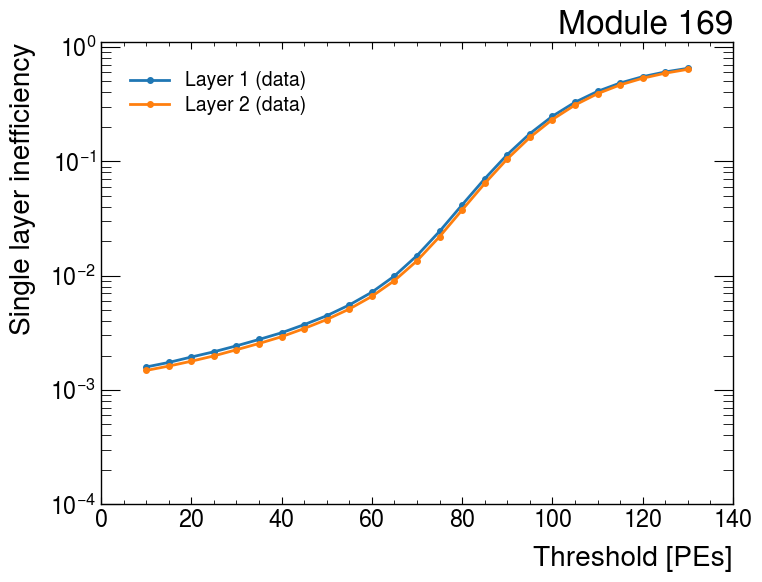

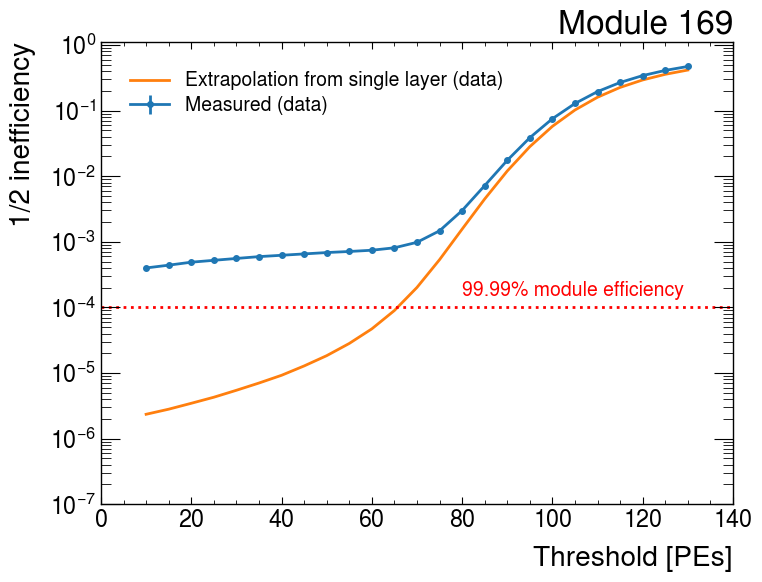

In [18]:
ineff_extrapolated_169_data = np.zeros_like(thresh)
ineff_layer1_169_data = np.zeros_like(thresh)
ineff_layer2_169_data = np.zeros_like(thresh)

for i in range(len(thresh)):
    eff_1 = pass_1_1_169_data[i]/nTrig_169_data[i]
    eff_2 = pass_2_0_169_data[i]/nTrig_169_data[i]
    
    ineff_1 = 1 - eff_1
    ineff_2 = 1 - eff_2
    
    eff_1of2 = ineff_1*eff_2 + \
               eff_1*ineff_2 + \
               eff_1*eff_2
    
    
    ineff_extrapolated_169_data[i] = 1 - eff_1of2
    ineff_layer1_169_data[i] = ineff_1
    ineff_layer2_169_data[i] = ineff_2
    
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_169_data, '.-', label='Layer 1 (data)')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_169_data, '.-', label='Layer 2 (data)')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')
ax.set_title('Module 169',loc='right')

plt.show()

ineff_module169_1of2_169_data = np.ones_like(thresh) - np.divide(pass_module169_1of2_169_data, nTrig_169_data)

error_module169_1of2_169_data = np.zeros_like(ineff_module169_1of2_169_data)
for i in range(len(ineff_module169_1of2_169_data)):
    error_module169_1of2_169_data[i] = np.sqrt(ineff_module169_1of2_169_data[i]*(1-ineff_module169_1of2_169_data[i])/nTrig_169_data[i])

fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_module169_1of2_169_data, yerr=error_module169_1of2_169_data, fmt='.-', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_169_data, '-', label='Extrapolation from single layer (data)')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(80, 0.00015, '99.99% module efficiency', c='r')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('1/2 inefficiency')
ax.set_title('Module 169',loc='right')

plt.show()

In [34]:
# List of variable to import
varlist=['PEs', 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 
         'subrunNumber', 'eventNumber', 'coincidencePosX','coincidencePDGid']
varlist_keep = ['PEs_testlayers', 'trackIntercept', 'trackChi2NDF', 'trackPoints', 'trackPEs', 
                'subrunNumber', 'eventNumber','PEsPerHit','coincidencePDGid']
#varlist_keep = ['PEs_testlayers', '169hits0', '169hits1', '169hits2', '169hits3', 'eventNumber'] 

ar_skim_list_cleanup_MC_v1 = []
ar_skim_list_169_MC_v1 = []

trackPEs_histbins = np.linspace(0, 5000, 251)
hTrackPEs_MC = np.histogram([], bins=trackPEs_histbins)

trackChi2NDF_histbins = np.linspace(0, 100, 101)
hTrackChi2NDF_MC = np.histogram([], bins=trackChi2NDF_histbins)

allevents = 0
cutevents_cleanup = 0
cutevents_169 = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist_mc_v1):
    if idx%100 == 0:
        print("Processing file: %s"%filename)
    allfiles += 1
    try:
        with uproot.open(filename) as file:

            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])
                # Positional cut for MC only

                ar = ar[(abs(ar["coincidencePosX"][:,1]+5604) < 50) & (abs(ar["coincidencePosX"][:,4] + 5604) < 50)]

                ar["PEs"] = ak.where(ar["PEs"] >= 5, ar["PEs"], 0)
                ar["hits"] = ak.where(ar["PEs"] > 0, 1, 0)

                FEB0_0 = (ak.sum(ar["PEs"][:,0,8:32], axis=-1)>10) #10:22
                FEB0_1 = (ak.sum(ar["PEs"][:,0,32:64], axis=-1)>10) #42:64

                FEB1_0 = (ak.sum(ar["PEs"][:,1,4:28], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar["PEs"][:,1,36:60], axis=-1)>10)

                FEB2_0 = (ak.sum(ar["PEs"][:,2,4:28], axis=-1)>10)
                FEB2_1 = (ak.sum(ar["PEs"][:,2,36:60], axis=-1)>10) #32:64

                FEB3_0 = (ak.sum(ar["PEs"][:,3,8:32], axis=-1)>10)
                FEB3_1 = (ak.sum(ar["PEs"][:,3,32:64], axis=-1)>10)

                FEB4_0 = (ak.sum(ar["PEs"][:,4,0:32], axis=-1)>10)
                FEB4_1 = (ak.sum(ar["PEs"][:,4,32:64], axis=-1)>10)

                FEB5_0 = (ak.sum(ar["PEs"][:,5,0:32], axis=-1)>10)
                FEB5_1 = (ak.sum(ar["PEs"][:,5,32:64], axis=-1)>10)

                FEB6_0 = (ak.sum(ar["PEs"][:,6,0:32], axis=-1)>10)
                FEB6_1 = (ak.sum(ar["PEs"][:,6,32:64], axis=-1)>10)

                FEB7_0 = (ak.sum(ar["PEs"][:,7,8:32], axis=-1)>10)
                FEB7_1 = (ak.sum(ar["PEs"][:,7,32:64], axis=-1)>10)

                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")

                ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2'] / (ar['trackPoints'] - 2), -999)
                ar['PEsPerHit'] = ak.where(ar['trackPoints'] > 2, ar['trackPEs'] / (ar['trackPoints']), -999)
                ar['trackIntercept'] = ar['trackIntercept'] - 20950.0
                ar["PEs_testlayers"] = ar["PEs"][:,np.arange(1,3)]
                
                hTrackPEs_run = np.histogram(ar["trackPEs"], bins=trackPEs_histbins)
                hTrackPEs_MC = np.add(hTrackPEs_MC, hTrackPEs_run)
                hTrackChi2NDF_run = np.histogram(ar['trackChi2NDF'], bins=trackChi2NDF_histbins)
                hTrackChi2NDF_MC = np.add(hTrackChi2NDF_MC, hTrackChi2NDF_run)


                #ar_cleanup = ar[(nTrigHits >=11) & (ar["trackChi2NDF"] < 25) & (ar["trackChi2NDF"] > 0)& (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700)] # & (ar["trackPEs"] < 2600)]
                ar_cleanup = ar[(nTrigHits >=12) &
                                (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]
                ar_169 = ar[FEB1_0 & FEB2_1]

                cutevents_cleanup += len(ar_cleanup["eventNumber"])
                cutevents_169 += len(ar_169["eventNumber"])

                # Append to the list
                ar_skim_list_cleanup_MC_v1.append(ar_cleanup[varlist_keep])
                ar_skim_list_169_MC_v1.append(ar_169[varlist_keep])

                filesloaded += 1
    except:
        continue
        
print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cleanup cuts: {0}".format(cutevents_cleanup))
print("Events after module 169 triggering: {0}".format(cutevents_169))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0012_v1/root/33/1c/nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.002001_00000005.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0012_v1/root/0a/c1/nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.002001_00000149.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0012_v1/root/2a/d4/nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.002001_00000308.root:CrvWidebandTest/run
257 files loaded out of 257
Total events: 10984888
Events after cleanup cuts: 194020
Events after module 169 triggering: 298693


In [35]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_0_cleanup_MC = np.zeros_like(thresh)
pass_1_1_cleanup_MC = np.zeros_like(thresh)
pass_2_0_cleanup_MC = np.zeros_like(thresh)
pass_2_1_cleanup_MC = np.zeros_like(thresh)
pass_module169_3of4_cleanup_MC = np.zeros_like(thresh)
nTrig_cleanup_MC = np.zeros_like(thresh)

PEs_hist_MC_v1, bin_edges = np.histogram([], np.linspace(0, 300, 301))

for i in range(len(ar_skim_list_cleanup_MC_v1)):
    ar_clean = ar_skim_list_cleanup_MC_v1[i]
    
    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
        FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
        FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
        FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])
        
        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")
        
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_MC_v1 = np.add(PEs_hist_MC_v1, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_MC_v1 = np.add(PEs_hist_MC_v1, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_MC_v1 = np.add(PEs_hist_MC_v1, run_hist)
        run_hist, bin_edges = np.histogram(ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1), bins=np.linspace(0, 300, 301))
        PEs_hist_MC_v1 = np.add(PEs_hist_MC_v1, run_hist)
        
        pass_1_0_cleanup_MC[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_1_1_cleanup_MC[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_2_0_cleanup_MC[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_2_1_cleanup_MC[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_module169_3of4_cleanup_MC[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_cleanup_MC[j] += ak.count(ar_clean["eventNumber"])

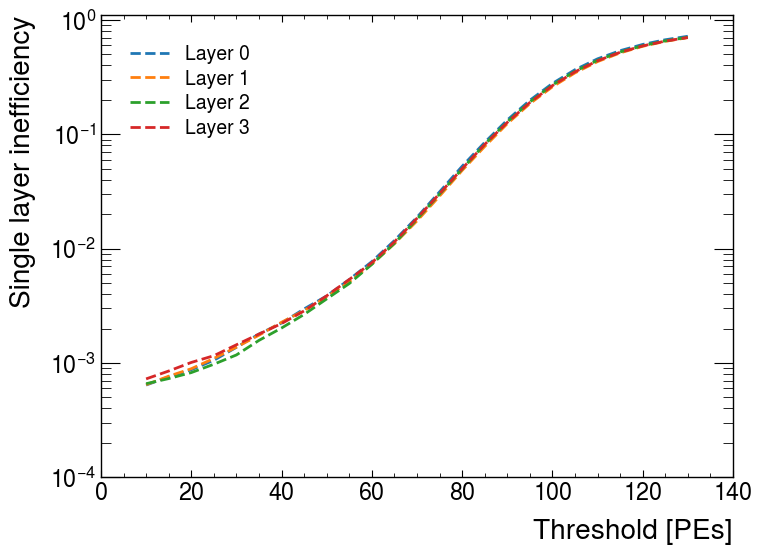

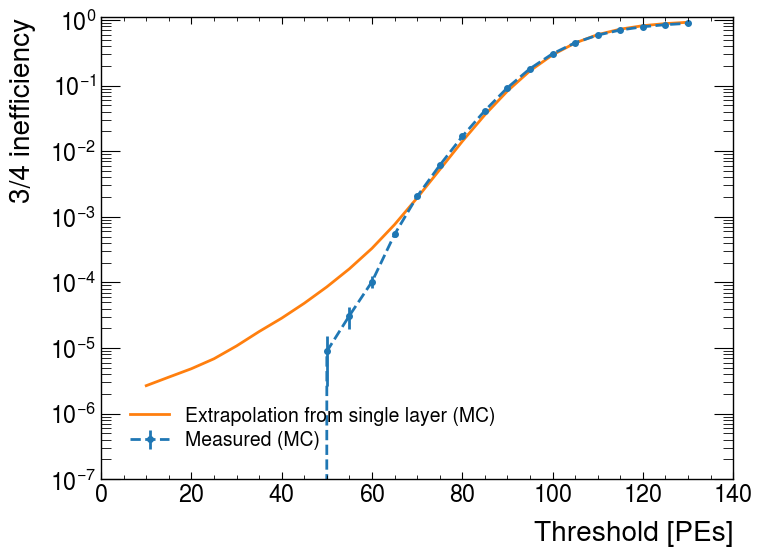

In [23]:
ineff_layer0_cleanup_MC_v1 = np.zeros_like(thresh)
ineff_layer1_cleanup_MC_v1 = np.zeros_like(thresh)
ineff_layer2_cleanup_MC_v1 = np.zeros_like(thresh)
ineff_layer3_cleanup_MC_v1 = np.zeros_like(thresh)

ineff_extrapolated_cleanup_MC_v1 = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_0_cleanup_MC[i]/nTrig_cleanup_MC[i]
    ineff_1 = 1 - pass_1_1_cleanup_MC[i]/nTrig_cleanup_MC[i]
    ineff_2 = 1 - pass_2_0_cleanup_MC[i]/nTrig_cleanup_MC[i]
    ineff_3 = 1 - pass_2_1_cleanup_MC[i]/nTrig_cleanup_MC[i]
    
    eff_avg = (pass_1_0_cleanup_MC[i]/nTrig_cleanup_MC[i] + \
               pass_1_1_cleanup_MC[i]/nTrig_cleanup_MC[i] + \
               pass_2_0_cleanup_MC[i]/nTrig_cleanup_MC[i] + \
               pass_2_1_cleanup_MC[i]/nTrig_cleanup_MC[i])/4
    
    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4
    
    ineff_layer0_cleanup_MC_v1[i] = ineff_0
    ineff_layer1_cleanup_MC_v1[i] = ineff_1
    ineff_layer2_cleanup_MC_v1[i] = ineff_2
    ineff_layer3_cleanup_MC_v1[i] = ineff_3
    ineff_extrapolated_cleanup_MC_v1[i] = 1 - eff_3of4
    
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer0_cleanup_MC_v1, '--', label='Layer 0')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_cleanup_MC_v1, '--', label='Layer 1')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_cleanup_MC_v1, '--', label='Layer 2')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer3_cleanup_MC_v1, '--', label='Layer 3')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

plt.show()

ineff_module169_3of4_cleanup_MC_v1 = np.ones_like(thresh) - np.divide(pass_module169_3of4_cleanup_MC, nTrig_cleanup_MC)

fig, ax = plt.subplots()

error_module169_3of4_cleanup_MC_v1 = np.zeros_like(ineff_module169_3of4_cleanup_MC_v1)
for i in range(len(ineff_module169_3of4_cleanup_MC_v1)):
    error_module169_3of4_cleanup_MC_v1[i] = np.sqrt(ineff_module169_3of4_cleanup_MC_v1[i]*(1-ineff_module169_3of4_cleanup_MC_v1[i])/nTrig_cleanup_MC[i])

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_module169_3of4_cleanup_MC_v1, yerr=error_module169_3of4_cleanup_MC_v1, fmt='.--', label='Measured (MC)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_cleanup_MC_v1, '-', label='Extrapolation from single layer (MC)')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()